# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

your answers here

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
%matplotlib inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
#your code here
df_bike_train=pd.read_csv("data/Bikeshare_train.csv", index_col = 0)
df_bike_train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [3]:
df_bike_test=pd.read_csv("data/Bikeshare_test.csv", index_col = 0)
df_bike_test.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0


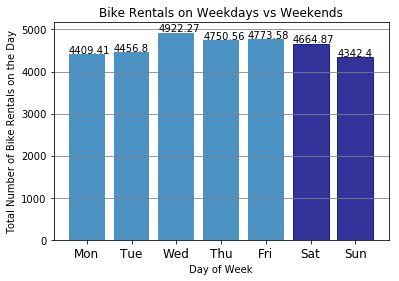

In [4]:
# How does the number of bike rentals vary between weekdays and weekends?
df_Mon = df_bike_train.loc[df_bike_train['day_of_week']==1.0]
df_Tue = df_bike_train.loc[df_bike_train['day_of_week']==2.0]
df_Wed = df_bike_train.loc[df_bike_train['day_of_week']==3.0]
df_Thu = df_bike_train.loc[df_bike_train['day_of_week']==4.0]
df_Fri = df_bike_train.loc[df_bike_train['day_of_week']==5.0]
df_Sat = df_bike_train.loc[df_bike_train['day_of_week']==6.0]
df_Sun = df_bike_train.loc[df_bike_train['day_of_week']==0.0]
Mon_mean = round(df_Mon["count"].mean(),2)
Tue_mean = round(df_Tue["count"].mean(),2)
Wed_mean = round(df_Wed["count"].mean(),2)
Thu_mean = round(df_Thu["count"].mean(),2)
Fri_mean = round(df_Fri["count"].mean(),2)
Sat_mean = round(df_Sat["count"].mean(),2)
Sun_mean = round(df_Sun["count"].mean(),2)
total_mean = df_bike_train["count"].mean()

labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
freqs = [Mon_mean, Tue_mean, Wed_mean, Thu_mean, Fri_mean, Sat_mean, Sun_mean]
x_coords = np.arange(len(labels))
plt.xticks(x_coords, labels, fontsize = 12)
bar = plt.bar(x_coords,freqs, alpha=0.8)
bar[5].set_color('navy')
bar[6].set_color('navy')
plt.ylabel("Total Number of Bike Rentals on the Day")
plt.xlabel("Day of Week")
plt.title("Bike Rentals on Weekdays vs Weekends")
plt.grid(axis = 'y', color ='gray', linestyle='-')
for p, ch in zip(x_coords, freqs):
    plt.annotate(str(ch), xy=(p-0.4,ch+100), va='center', fontsize = 10)

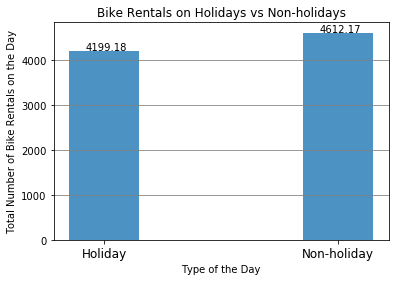

In [5]:
# How about bike rentals on holidays?
df_holiday = df_bike_train.loc[df_bike_train['holiday']==1.0]
df_nonholiday = df_bike_train.loc[df_bike_train['holiday']==0.0]
holiday_mean = round(df_holiday['count'].mean(),2)
nonholiday_mean = round(df_nonholiday['count'].mean(),2)

labels = ["Holiday", "Non-holiday"]
freqs = [holiday_mean, nonholiday_mean]
x_coords = np.arange(len(labels))
plt.xticks(x_coords, labels, fontsize = 12)
plt.bar(x_coords, freqs, alpha=0.8, width = 0.3)
plt.ylabel("Total Number of Bike Rentals on the Day")
plt.xlabel("Type of the Day")
plt.title("Bike Rentals on Holidays vs Non-holidays")
plt.grid(axis = 'y', color ='gray', linestyle='-')
for p, ch in zip(x_coords, freqs):
    plt.annotate(str(ch), xy=(p-0.08,ch+90), va='center', fontsize = 10)

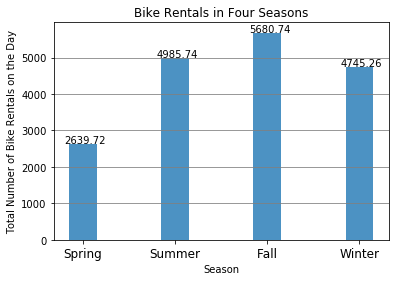

In [6]:
# What effect does the season have on the bike rentals on a given day?
df_spring = df_bike_train.loc[df_bike_train['season']==1.0]
df_summer = df_bike_train.loc[df_bike_train['season']==2.0]
df_fall = df_bike_train.loc[df_bike_train['season']==3.0]
df_winter = df_bike_train.loc[df_bike_train['season']==4.0]
spring_mean = round(df_spring['count'].mean(),2)
summer_mean = round(df_summer['count'].mean(),2)
fall_mean = round(df_fall['count'].mean(),2)
winter_mean = round(df_winter['count'].mean(),2)

labels = ["Spring", "Summer", "Fall", "Winter"]
freqs = [spring_mean, summer_mean, fall_mean, winter_mean]
x_coords = np.arange(len(labels))
plt.xticks(x_coords, labels, fontsize = 12)
plt.bar(x_coords, freqs, alpha=0.8, width = 0.3)
plt.ylabel("Total Number of Bike Rentals on the Day")
plt.xlabel("Season")
plt.title("Bike Rentals in Four Seasons")
plt.grid(axis = 'y', color ='gray', linestyle='-')
for p, ch in zip(x_coords, freqs):
    plt.annotate(str(ch), xy=(p-0.2,ch+100), va='center', fontsize = 10)

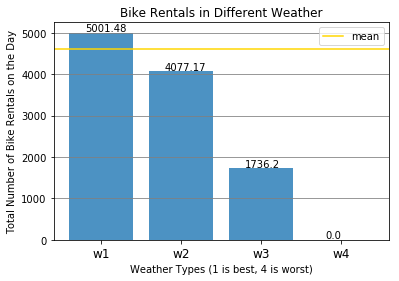

In [7]:
# Is the number of bike rentals lower than average when there is rain or snow?
df_w1 = df_bike_train.loc[df_bike_train['weather']==1.0]
df_w2 = df_bike_train.loc[df_bike_train['weather']==2.0]
df_w3 = df_bike_train.loc[df_bike_train['weather']==3.0]
df_w4 = df_bike_train.loc[df_bike_train['weather']==4.0]
w1_mean = round(df_w1['count'].mean(),2)
w2_mean = round(df_w2['count'].mean(),2)
w3_mean = round(df_w3['count'].mean(),2)
w4_mean = round(df_w4['count'].mean(),2) # there is no weather type 4 in the training set
if df_w4.empty:
    w4_mean = 0.0

labels = ["w1", "w2", "w3", "w4"]
freqs = [w1_mean, w2_mean, w3_mean, w4_mean]
x_coords = np.arange(len(labels))
plt.xticks(x_coords, labels, fontsize = 12)
plt.bar(x_coords, freqs, alpha=0.8)
plt.ylabel("Total Number of Bike Rentals on the Day")
plt.xlabel("Weather Types (1 is best, 4 is worst)")
plt.title("Bike Rentals in Different Weather")
plt.grid(axis = 'y', color ='gray', linestyle='-')
plt.axhline(y=total_mean, color="gold", label="mean")
plt.legend(loc="best")
for p, ch in zip(x_coords, freqs):
    plt.annotate(str(ch), xy=(p-0.2,ch+100), va='center', fontsize = 10)

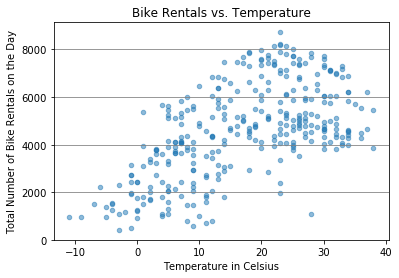

In [8]:
# How does temperature effect bike rentals?
df_bike_train.plot(kind="scatter", x="temp", y="count", alpha = 0.5)
plt.ylabel("Total Number of Bike Rentals on the Day")
plt.xlabel("Temperature in Celsius")
plt.title("Bike Rentals vs. Temperature")
plt.grid(axis = 'y', color ='gray', linestyle='-')

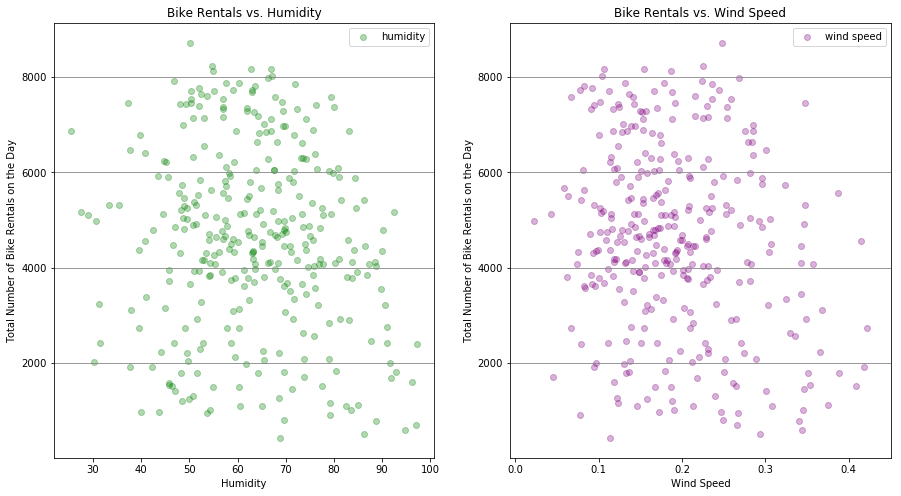

In [9]:
# Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
humidity = df_bike_train["humidity"].values
windspeed = df_bike_train['windspeed'].values
count = df_bike_train['count'].values
ax[0].scatter(x=humidity, y=count, alpha = 0.3, color="green", label = "humidity")
ax[0].set_ylabel("Total Number of Bike Rentals on the Day")
ax[0].set_xlabel("Humidity")
ax[0].set_title("Bike Rentals vs. Humidity")
ax[0].grid(axis = 'y', color ='gray', linestyle='-')
ax[0].legend(loc="best")

ax[1].scatter(x=windspeed, y=count, alpha = 0.3, color="purple", label = "wind speed")
ax[1].set_ylabel("Total Number of Bike Rentals on the Day")
ax[1].set_xlabel("Wind Speed")
ax[1].set_title("Bike Rentals vs. Wind Speed")
ax[1].grid(axis = 'y', color ='gray', linestyle='-')
ax[1].legend(loc="best")

your answers here
## Answer:
### 1. How does the number of bike rentals vary between weekdays and weekends?
By calculating the means of bike rentals on each day of a week, we can see that they do not differ a lot from each other. Bike rentals on Saturdays are almost the same as usual weekdays, but rentals on Sundays decrease a little bit, but it doesn't look like a siginificant decrease. So generally, the number of bike rentals doesn't vary a lot between weekdays and weekends.

### 2. How about bike rentals on holidays?
By calculating the means of bike rentals on holidays and non-holidays, we can see that people are more likely to rent a bike on non-holidays (about 4200 on each holiday and 4600 on each non-holiday, on average).

### 3. What effect does the season have on the bike rentals on a given day?
By calculating the means of bike rentals in different seasons, we can see that spring has the lowest number of bike rentals, fall has the highest, and summer and winter have about the same. This seems weird that spring is the lowest rather than winter. My guess is that maybe the mean of bike rentals in spring has some extreme low values which affect the mean value, or maybe that is just the reality.

### 4. Is the number of bike rentals lower than average when there is rain or snow?
By calculating the means of bike rentals on different weather, we can see there is a clear trend that as weather gets worse, fewer people will rent bikes. So the number of bike rentals is lower than average when there is rain or snow.

### 5. How does temperature effect bike rentals?
When temperature is very low, that is below 10 degree Celsius, not many people will rent bikes. As temperature goes up, bike rentals increases as well, and the peak is at about 15 to 25 degree Celsius. If temperature keeps increasing, bike rentals will decrease a little bit, but still higher than the number in cold weather.

### 6. Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?
Among all the variables above, the day of a week (Monday, Tuesday, etc.) seems independent with the bike rentals, as we can see that weekday rentals do not vary a lot from weekend rentals. But the types of day is not actually numeric, they are just categoties. 

Humidity and wind speed do not affect bike rentals very much, as the scatter plots show random patterns.

Temperature clearly affects bike rentals. When it is very cold, bike rentals are low; as temperature increases, bike rental grows but when it is super hot, bike rentals decrease again. From the temperature vs Bike Rental scatter plot, the pattern looks like a concave-down parabola to me.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [10]:
# your code here
# df_bike_train.season.unique()
# convert categorical attributes into multiple binary attributes; delete the first binary column
df_bike_train['season'] = df_bike_train['season'].astype("category")
df_bike_train['month'] = df_bike_train['month'].astype("category")
df_bike_train['holiday'] = df_bike_train['holiday'].astype("category")
df_bike_train['day_of_week'] = df_bike_train['day_of_week'].astype("category")
df_bike_train['workingday'] = df_bike_train['workingday'].astype("category")
df_bike_train['weather'] = df_bike_train['weather'].astype("category")

df_train = pd.get_dummies(df_bike_train,columns=["season","month","holiday","day_of_week","workingday","weather"],\
                             drop_first = True)
# Rename the columns
df_train = df_train.rename(columns={"season_2.0": "Summer", "season_3.0": "Fall", "season_4.0": "Winter",\
                                    "month_2.0": "Feb", "month_3.0": "Mar", "month_4.0": "Apr", "month_5.0": "Mar", \
                                    "month_6.0": "Jun", "month_7.0": "Jul", "month_8.0": "Aug", "month_9.0": "Sep", \
                                    "month_10.0": "Oct", "month_11.0": "Nov", "month_12.0": "Dec", \
                                    "holiday_1.0": "Holiday", "day_of_week_1.0": "Mon", "day_of_week_2.0": "Tue", \
                                    "day_of_week_3.0": "Wed", "day_of_week_4.0": "Thu", "day_of_week_5.0": "Fri", \
                                    "day_of_week_6.0": "Sat", "workingday_1.0": "Workday", \
                                    "weather_2.0": "Mist", "weather_3.0": "Light_rain/snow"})

# df_train.dtypes
df_train.describe()

,temp,atemp,humidity,windspeed,count,Summer,Fall,Winter,Feb,Mar,...,Holiday,Mon,Tue,Wed,Thu,Fri,Sat,Workday,Mist,Light_rain/snow
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,17.018127,19.543807,63.385776,0.190833,4598.447130,0.259819,0.265861,0.256798,0.066465,0.075529,...,0.033233,0.175227,0.135952,0.123867,0.123867,0.145015,0.135952,0.670695,0.329305,0.030211
std,11.192515,9.930991,14.334789,0.078240,1935.319338,0.439199,0.442459,0.437528,0.249471,0.264643,...,0.179515,0.380736,0.343256,0.329929,0.329929,0.352649,0.343256,0.470672,0.470672,0.171428
min,-11.000000,-6.000000,25.416700,0.022392,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.500000,11.000000,52.702900,0.133083,3370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18.000000,21.000000,63.291700,0.178479,4648.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,26.000000,27.000000,73.500000,0.235380,5981.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,38.000000,39.000000,97.250000,0.421642,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_bike_test['season'] = df_bike_test['season'].astype("category")
df_bike_test['month'] = df_bike_test['month'].astype("category")
df_bike_test['holiday'] = df_bike_test['holiday'].astype("category")
df_bike_test['day_of_week'] = df_bike_test['day_of_week'].astype("category")
df_bike_test['workingday'] = df_bike_test['workingday'].astype("category")
df_bike_test['weather'] = df_bike_test['weather'].astype("category")
# df_bike_test.dtypes
df_test = pd.get_dummies(df_bike_test,columns=["season","month","holiday","day_of_week","workingday","weather"],\
                             drop_first = True)
# df_test.dtypes
df_test.head()

,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,month_2.0,month_3.0,...,holiday_1.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,workingday_1.0,weather_2.0,weather_3.0
0,2.0,6.0,56.2083,0.194037,3830.0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,1.0,3.0,65.2917,0.350133,2114.0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,36.0,37.0,56.8333,0.149883,915.0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,8.0,12.0,49.0833,0.268033,4322.0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,28.0,29.0,69.7083,0.215171,6591.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Standardize the continuous predictors to have zero mean and std of 1
temp_mean = df_train["temp"].mean()
temp_std = df_train["temp"].std()
atemp_mean = df_train["atemp"].mean()
atemp_std = df_train["atemp"].std()
humidity_mean = df_train["humidity"].mean()
humidity_std = df_train["humidity"].std()
windspeed_mean = df_train["windspeed"].mean()
windspeed_std = df_train["windspeed"].std()

df_train["temp"] = (df_train["temp"]-temp_mean) / temp_std
df_train["atemp"] = (df_train["atemp"]-atemp_mean) / atemp_std
df_train["humidity"] = (df_train["humidity"]-humidity_mean) / humidity_std
df_train["windspeed"] = (df_train["windspeed"]-windspeed_mean) / windspeed_std
df_train.describe()

,temp,atemp,humidity,windspeed,count,Summer,Fall,Winter,Feb,Mar,...,Holiday,Mon,Tue,Wed,Thu,Fri,Sat,Workday,Mist,Light_rain/snow
count,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15,4598.447130,0.259819,0.265861,0.256798,0.066465,0.075529,...,0.033233,0.175227,0.135952,0.123867,0.123867,0.145015,0.135952,0.670695,0.329305,0.030211
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1935.319338,0.439199,0.442459,0.437528,0.249471,0.264643,...,0.179515,0.380736,0.343256,0.329929,0.329929,0.352649,0.343256,0.470672,0.470672,0.171428
min,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,3370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,4648.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,5981.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_test["temp"] = (df_test["temp"]-temp_mean) / temp_std
df_test["atemp"] = (df_test["atemp"]-atemp_mean) / atemp_std
df_test["humidity"] = (df_test["humidity"]-humidity_mean) / humidity_std
df_test["windspeed"] = (df_test["windspeed"]-windspeed_mean) / windspeed_std
df_test = df_test.rename(columns={"season_2.0": "Summer", "season_3.0": "Fall", "season_4.0": "Winter",\
                                    "month_2.0": "Feb", "month_3.0": "Mar", "month_4.0": "Apr", "month_5.0": "Mar", \
                                    "month_6.0": "Jun", "month_7.0": "Jul", "month_8.0": "Aug", "month_9.0": "Sep", \
                                    "month_10.0": "Oct", "month_11.0": "Nov", "month_12.0": "Dec", \
                                    "holiday_1.0": "Holiday", "day_of_week_1.0": "Mon", "day_of_week_2.0": "Tue", \
                                    "day_of_week_3.0": "Wed", "day_of_week_4.0": "Thu", "day_of_week_5.0": "Fri", \
                                    "day_of_week_6.0": "Sat", "workingday_1.0": "Workday", \
                                    "weather_2.0": "Mist", "weather_3.0": "Light_rain/snow"})
df_test.describe()

,temp,atemp,humidity,windspeed,count,Summer,Fall,Winter,Feb,Mar,...,Holiday,Mon,Tue,Wed,Thu,Fri,Sat,Workday,Mist,Light_rain/snow
count,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.00000,400.000000,...,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,-0.128713,-0.121217,-0.076029,-0.008111,4514.21250,0.245000,0.250000,0.232500,0.08750,0.092500,...,0.02500,0.117500,0.147500,0.157500,0.157500,0.140000,0.150000,0.695000,0.345000,0.02750
std,1.052309,1.061183,0.988182,0.983825,2092.60635,0.430626,0.433555,0.422955,0.28292,0.290093,...,0.15632,0.322418,0.355048,0.364728,0.364728,0.347422,0.357519,0.460984,0.475964,0.16374
min,-2.324601,-2.370741,-4.421814,-1.858750,22.00000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,-1.073765,-1.061707,-0.879771,-0.714163,2875.25000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,-0.180310,-0.155453,-0.092312,-0.098286,4516.00000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
75%,0.802489,0.851495,0.665606,0.534842,6174.75000,0.000000,0.250000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
max,1.963980,2.261224,2.202511,4.046877,10045.00000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


your answers here
## Answer:
### 1. Why can't they (categorical attributes) be directly used as predictors?
Although attributes like season, day of a week, weather are assigned with numerical values, those numbers do not make any numerical sense. We cannot say that Saturday is bigger than Monday because Saturday has value of 6 and Monday only has value of 1. Categorical variables represent a qualitative measurement of data, and must be converted into quantitative values to analyze the data. If they are directly used as predictors, it will hurt the performance of the model. 

### 2. Why is it okay to not have a binary column for the $K_j$-th category?
The last category can be viewed as a control group, which is compared to the rest of (j-1) categories. This is okay because even if one converts the last category as well, one cannot get additional information. For example, consider a category variable with "yes" and "no." We only need to record "yes," and the rest will naturally belong to the "no" group. In this way, we reduce the redudancy due to colinearity.

### 3. Why shouldn't we include the test set observations in computing the mean and SD?
We are required to only use the parameters estimated from the training data and apply the model to the test data. So basically we are assuming that the whole test dataset is unknown, that we have no information about that yet. Therefore, to standardize the test dataset, we can only use the mean and SD from the training set.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [14]:
# your code here
y_train = df_train['count'].values
y_test = df_test['count'].values
all_predictors = [col for col in df_train.columns if col not in ['count']]
X_train = df_train[all_predictors].values
X_test = df_test[all_predictors].values

X_train_reg = sm.add_constant(X_train)
multi_model = sm.OLS(y_train, X_train_reg)
results = multi_model.fit()
print('training R^2: ', results.rsquared)

X_test_reg = sm.add_constant(X_test)
y_pred = results.predict(X_test_reg)
r2_test = r2_score(y_test, y_pred)
print('test R^2: ', r2_test)

training R^2:  0.576128178313
test R^2:  0.249342111465


In [15]:
p_values = results.pvalues.tolist()
coeffs = results.params
all_predictors.insert(0, "constant")
coeffs_dict = dict(zip(all_predictors, coeffs))
param_dict = dict(zip(all_predictors, p_values))
sig_params_dict = {k:v for k,v in param_dict.items() if v < 0.05}
pos_coeffs_dict = {k:v for k,v in coeffs_dict.items() if v > 0}
print("Significant predictors are:\n",sig_params_dict)
print("Positive predictors are:\n",pos_coeffs_dict)
# len(pos_coeffs_dict)

Significant predictors are:
 {'constant': 9.368885172928495e-16, 'humidity': 2.020826785185311e-06, 'windspeed': 0.0017442352202303754, 'Winter': 0.016124082215812522}
Positive predictors are:
 {'constant': 3681.7765315173492, 'temp': 925.73384985663097, 'atemp': 312.43407188889796, 'Summer': 898.82903949054162, 'Fall': 1032.8815748448651, 'Winter': 1226.1865426521563, 'Feb': 88.940092674465404, 'Mar': 333.3490864173865, 'Jun': 119.59044920382986, 'Nov': 405.14456610360185, 'Dec': 486.25090366728642, 'Holiday': 112.68164522168468, 'Fri': 170.51134686862832, 'Sat': 61.256029874867409, 'Workday': 111.06689939418894, 'Mist': 465.14500995709074, 'Light_rain/snow': 308.15314173754462}


In [16]:
print(results.summary())
# print(all_predictors)
# param_dict

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        19:28:34   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3681.7765    433.655      8.490      0.0

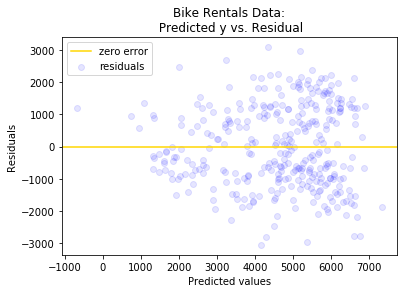

In [17]:
y_pred = results.predict(X_train_reg)
errors = y_train - y_pred
plt.scatter(y_pred, errors, color="blue", alpha=0.1, label="residuals")
plt.axhline(y=0, color="gold", label="zero error")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Bike Rentals Data:\n Predicted y vs. Residual")
plt.legend(loc="best")

your answers here
## Answer:
### 1. Which among the predictors have a positive correlation with the number of bike rentals?
temp; atemp; Summer; Fall; Winter; Feb; Mar; Apr; Sep; Oct; Nov; Wed; Thu; Fri; Sat; workday

In total, there are 16 predictors (constant excluded here) which have a positive correlation with the number of bike rentals.

### 2. Does the day of a week have a relationship with bike rentals?
None of the day_of_week predictor has a significant p-value, so the day of a week does not have a relationship with bike rentals.

### 3. Does the month influence the bike rentals?
None of the month predictor has a significant p-value, so the month does not influence the bike rentals much.

### 4. What effect does a holiday have on bike rentals?
The holiday does not have a significant p-value. Its confidence interval is very wide, and is from negative to positive, so it does not affect bike rentals much.

### 5. Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.
The coefficient assigned to temp is 926 and the coefficient assigned to atemp is 312.
Both temp and atemp affects the bike rentals, since generally, more people want bikes as temperature goes up. But these two predictors are highly correlated, and since the model takes temp as the first predictor, it assigns a high coefficient to it. So when it encounters the second predictor, it assigns a positive but lower coefficient to the second predictor.

### 6. Residual Plot: Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?

Yes, the plot reveals a non-linear relationship between the predictors and response. The residual plot seems to have the problem of heteroscedasticity, since the residuals seem to expand like a fan, which means the variance of the error terms grows as the predicted values increase. For example, if the true model is y = x^2 but we fit it with y = x, then the error will increases as x grows.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

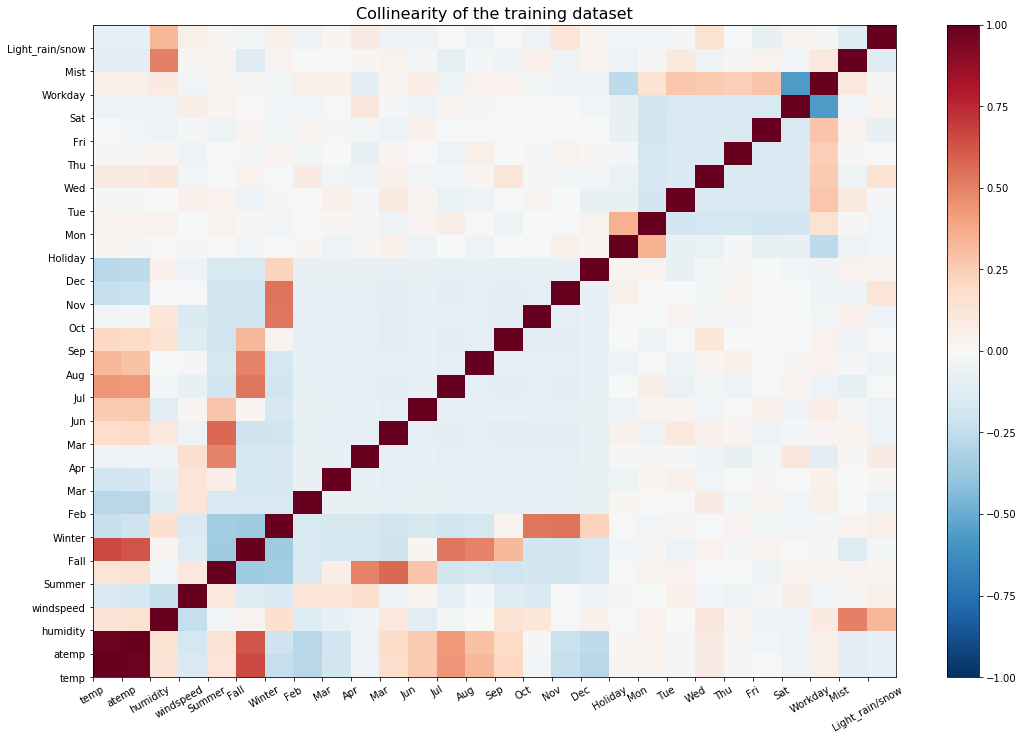

In [18]:
# your code here
df_train_predictors = df_train.copy()
del df_train_predictors['count']

df_train_matrix = df_train_predictors.values

corr = np.corrcoef(df_train_matrix.T)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 12)
plt.title("Collinearity of the training dataset", fontsize=16)
labels = [col for col in df_train.columns if col not in ['count']]
x_coords = np.arange(len(labels))
plt.xticks(x_coords, labels, rotation = 30)
plt.yticks(x_coords, labels)
plt.pcolor(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

your answers here
## Answer:
### 1. Does the data suffer from multi-collinearity?
Yes, there are several multi-collinearity we can see from the heatmap, where dark red and dark blue represent high positive and high negative correlation.
- First, atemp and temp have very positive correlation.
- Second, workday and Saturday have highly negative correlation, which makes sense because Saturday is a weekend and definitely not a workday. More generally, the box containing days of a week and the box containing different months are light blue, because if a day is Monday then it cannot be Tuesday, and if a month is March then it cannot be April, etc.
- The bottom left corner has a few blue and orange squares, between months/seasons and temperature. This also makes sense becuase when it is winter, December for example, then temperature is low; and when it is summer, say August, then temperature must be higher.
- When the weather is mist or light rain or snow, the humidity increases and thus we see the two reddish squares indicating positive correlation.

### 2. Are there predictors that fall into natural groups based on the correlation values?
Yes.
- Months are like "subgroups" of seasons, for example, June, July and August belong to summer.
- Monday through Friday are basically workdays, and weekends and holidays are non-workdays.
- Temperature and relative temperature are basically the same thing.

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [19]:
# your code here
regression_model = LinearRegression(fit_intercept=True)
def get_bic(X_train, y_train):
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.bic

### Step-wise Forward Selection

In [20]:
# step-wise forward selecetion
all_predictors = [col for col in df_train.columns if col not in ['count']]
X_train = df_train[all_predictors].values
predictors = [([], float("inf"))]

for k in range(1, len(all_predictors)):
    best_k_minus_1 = predictors[-1][0]
    bics = []
    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    
    for predictor in new_predictors:
        k_predictors = best_k_minus_1 + [predictor]   
        X_train = df_train[k_predictors].values
        b = get_bic(X_train, y_train)
            
        regression_model.fit(X_train, y_train)
        bics.append(b)
        
    best_k = best_k_minus_1 + [new_predictors[np.argmin(bics)]]
    predictors.append((best_k, np.min(bics)))

best_bicf_set = sorted(predictors, key=lambda t: t[1])[0]
# best_predictor_set
X_train = df_train[best_bicf_set[0]].values 
X_test = df_test[best_bicf_set[0]].values  

regression_model.fit(X_train, y_train)

print('best predictor set (bic forward):', best_bicf_set[0])
print('training R^2:', regression_model.score(X_train, y_train))
print('test R^2:', regression_model.score(X_test, y_test))

best predictor set (bic forward): ['atemp', 'humidity', 'Winter', 'Sep', 'Summer', 'Light_rain/snow', 'windspeed']
training R^2: 0.532513398328
test R^2: 0.27579228429


### Step-wise Backward Selection

In [21]:
# step-wise backward selection
all_predictors = [col for col in df_train.columns if col not in ['count']]
X_train = df_train[all_predictors].values
predictors = [(all_predictors, get_bic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    bics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = df_train[k_minus_1].values

        bics.append(get_bic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(bics)]]))
    predictors.append((best_k_minus_1, np.min(bics)))    

In [22]:
best_bicb_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = df_train[best_bicb_set[0]].values 
X_test = df_test[best_bicb_set[0]].values  

regression_model.fit(X_train, y_train)

print('best predictor set (bic backward):', best_bicb_set[0])
print('training R^2:', regression_model.score(X_train, y_train))
print('test R^2:', regression_model.score(X_test, y_test))

best predictor set (bic backward): ['temp', 'Aug', 'Fall', 'Jun', 'Light_rain/snow', 'humidity', 'windspeed', 'Winter', 'Summer', 'Jul']
training R^2: 0.556442132115
test R^2: 0.270481135658


your answers here
## Answer: 

### 1. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)?
- BIC Forward Selection: atemp, humidity, Winter, Sep, Summer, Light_rain/snow, windspeed

BIC stepwise forward selection eliminated temperature(temp) and just kept "atemp." It also eliminated most of months except Sep, and we can see that Sep does not belong to the season that it keeps, which is summer. It also eliminated all days of a week (Mon, Tue, etc.), as well as holiday or not and workday or not. But the two correlated predictors, humidity and rainy/snowy weather are still kept in this model.

- BIC Backward Selection: Jul, Aug, humidity, Winter, Jun, windspeed, Light_rain/snow, temp, Summer, Fall

BIC stepwise backward selection eliminated "atemp" and just kept "temp. It also eliminated all days of a week (Mon, Tue, etc.), as well as holiday or not and workday or not. However, the months it kept are July, August and June, which all belong to the season of summer that it kept. So this model still has some redundant predictors.

### 2. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?
- Multiple Linear Regression in Part(b) gives test $R^2$ score of 0.249342111465.
- BIC forward selection gives test $R^2$ score of 0.27579228429.
- BIC backward selection gives test $R^2$ score of 0.270481135658.

So the two step-wise selection improves the test $R^2$ scores for the fitted models a little bit, but it is not huge improvement generally.

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [23]:
# your code here
y_non_test = df_train['count'].values
y_test = df_test['count'].values

regression_model = LinearRegression(fit_intercept=True)

all_predictors = [col for col in df_train.columns if col not in ['count']]
X_non_test_all = df_train[all_predictors].values
X_test_all = df_test[all_predictors].values

bicf_predictors = ['atemp', 'humidity', 'Winter', 'Sep', 'Summer', 'Light_rain/snow', 'windspeed']
X_non_test_bicf = df_train[bicf_predictors].values
X_test_bicf = df_test[bicf_predictors].values

bicb_predictors = ['Jul', 'Aug', 'humidity', 'Winter', 'Jun', 'windspeed', 'Light_rain/snow', 'temp', 'Summer', 'Fall']
X_non_test_bicb = df_train[bicb_predictors].values
X_test_bicb = df_test[bicb_predictors].values

kf = KFold(n_splits=10)

validation_R2_all = []
validation_R2_bicf = []
validation_R2_bicb = []

for train_index, val_index in kf.split(X_non_test_all):
    X_train_all, X_val_all = X_non_test_all[train_index], X_non_test_all[val_index]
    y_train_all, y_val_all = y_non_test[train_index], y_non_test[val_index]

    regression_model.fit(X_train_all, y_train_all)
    validation_R2_all.append(regression_model.score(X_val_all, y_val_all))
x_val_scores_all = np.mean(validation_R2_all)
print("Average R2 score of 10 validation sets using the model with all predictors: \n", x_val_scores_all)

for train_index, val_index in kf.split(X_non_test_bicf):
    X_train_bicf, X_val_bicf = X_non_test_bicf[train_index], X_non_test_bicf[val_index]
    y_train_bicf, y_val_bicf = y_non_test[train_index], y_non_test[val_index]

    regression_model.fit(X_train_bicf, y_train_bicf)
    validation_R2_bicf.append(regression_model.score(X_val_bicf, y_val_bicf))
x_val_scores_bicf = np.mean(validation_R2_bicf)
print("Average R2 score of 10 validation sets using the model with BIC forward selection: \n", x_val_scores_bicf)


for train_index, val_index in kf.split(X_non_test_bicb):
    X_train_bicb, X_val_bicb = X_non_test_bicb[train_index], X_non_test_bicb[val_index]
    y_train_bicb, y_val_bicb = y_non_test[train_index], y_non_test[val_index]

    regression_model.fit(X_train_bicb, y_train_bicb)
    validation_R2_bicb.append(regression_model.score(X_val_bicb, y_val_bicb))
x_val_scores_bicb = np.mean(validation_R2_bicb)
print("Average R2 score of 10 validation sets using the model with BIC backward selection: \n", x_val_scores_bicb)

Average R2 score of 10 validation sets using the model with all predictors: 
 0.34257855094
Average R2 score of 10 validation sets using the model with BIC forward selection: 
 0.440268095121
Average R2 score of 10 validation sets using the model with BIC backward selection: 
 0.460332743533


In [24]:
all_predictors = [col for col in df_train.columns if col not in ['count']]
X_train_all = df_train[all_predictors].values
X_test_all = df_test[all_predictors].values
regression_model.fit(X_train_all, y_train)
print("test set R^2 score using all predictors:\n", regression_model.score(X_test_all, y_test))

X_train_bicf = df_train[best_bicf_set[0]].values 
X_test_bicf = df_test[best_bicf_set[0]].values  

regression_model.fit(X_train_bicf, y_train)
print("test set R^2 score using bic forward selection:\n", regression_model.score(X_test_bicf, y_test))

X_train_bicb = df_train[best_bicb_set[0]].values 
X_test_bicb = df_test[best_bicb_set[0]].values

regression_model.fit(X_train_bicb, y_train)
print("test set R^2 score using bic backward selection:\n", regression_model.score(X_test_bicb, y_test))

test set R^2 score using all predictors:
 0.249342111465
test set R^2 score using bic forward selection:
 0.27579228429
test set R^2 score using bic backward selection:
 0.270481135658


your answers here
### 1. Compare the average $R^2$ scores across all 10 validation sets for each model.
We can see that the average $R^2$ scores using 10-fold validation significantly dropped comparing to the previous training set $R^2$ scores without validation sets. This is because cross validation is an effective way to detect over-fitting. Also, notice that the $R^2$ score with all predictors drops the most among the three. I think that is because that model is the one suffering the most severe overfitting problem among the three models.

### 2. Compute the $R^2$ scores for the test set. Do the results agree with the cross-validation? Why or why not?
Yes, as we can see that the test $R^2$ score using all predictors is the lowest among the three. This is because using 10-fold cross validation, we've already detect the problem of overfitting beforehand, even though the training set using all predictors has a high $R^2$ score, so we are not surprised that test set R^2 score is even lower than the one averaged from validation sets. Also, the cross validation shows that Bic foward and Bic backward have very close R^2 scores, and using the test set, we can see the R^2 scores are very close too.

The reason that the results from test set agree with cross validaiton is because it is an extra process to see how the model will generalize to another dataset. Using 10-fold cross validation and taking the average is even stronger to limit the problem of overfitting.